In [1]:
import bayesian_cart_complexity as BC
from sklearn.datasets import load_breast_cancer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets, svm, metrics
import random


Definimos la densidad de un árbol como:
$$ Density(T)=\frac{N_{leafs}}{2^{depth(T)}} = \frac{N_{innernode}+ 1}{2^{depth(T)}}$$
$Density(T) = 1$ cuando tiene todos las hojas en el mismo nivel.

$Density(T) << 1$ más chico si las hojas difieren de altura con la máxima.

### Cargamos los dataset
#### load_breast_cancer de Sklearn

In [105]:
data = load_breast_cancer()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['target'] = data['target']
full_data = load_breast_cancer()
feature_names = full_data.feature_names
labels_names = full_data.target_names

In [106]:
df = load_breast_cancer()
feature = df.data
label = df.target
X_train, X_test, y_train, y_test = train_test_split(feature, label)

In [309]:
def even_gamma(N):
    return lambda x : 0.25 * ((N-x)/(N-1))

def cuadratic_gamma(N):
    return lambda x : 0.25 * ((N-x)/(N-1))**2

def sqrt_gamma(N):
    return lambda x : 0.25 * ((N-x)/(N-1))**(1/2)

def inverse_lineal(N, N_leaf_f = 50):
    return lambda x : 1/( ((N_leaf_f- 3)/N) * (x-1) + 3)

In [108]:
def plot_accuracy(clf , X_train, y_train, X_test, y_test):
    path = clf.path
    alpha = clf.alpha
    beta = clf.beta
    prob = clf.prob
    accuracy_train = clf.path_acurracy(X_train,y_train)
    accuracy_test = clf.path_acurracy(X_test,y_test)
    figure = plt.figure(figsize = (15,8))
    plt.plot(list(range(len(accuracy_train))),accuracy_train, label = "train")
    plt.plot(list(range(len(accuracy_test))),accuracy_test, label = "test")
    plt.suptitle(f"Accuracy vs Iteración")
    plt.title(f"[$\\alpha$ = {alpha}, $\\beta$ = {beta}, $prob$ = {prob}]")
    plt.xlabel("Iteración")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [109]:
def plot_info(clf):
    path = clf.path
    alpha = clf.alpha
    beta = clf.beta
    prob = clf.prob
    path_info = clf.path_info()
    fig, (ax1, ax2) = plt.subplots(2,1, figsize= [15,10])
    fig.suptitle(f'[$\\alpha$ = {alpha}, $\\beta$ = {beta}, $prob$ = {prob}]')
    
    ax1.plot(path_info[:,0] ,label="depth" )
    ax1.plot(path_info[:,1] ,label="leafs" )
    ax1.set_title("Estructura vs Iteración")
    ax1.set_xlabel("Iteración")
    ax1.set_ylabel("Profundida y hojas")
    ax1.legend()
    
    ax2.plot(path_info[1:,1]/(2**path_info[1:,0]) ,label="density" )
    ax2.legend()
    ax2.set_title("Densidad del Árbol vs Iteración")
    ax2.set_xlabel("Iteración")
    ax2.set_ylabel("Densidad del Árbol")
    plt.show()

In [304]:
def plot_inverse_leafs(clf):
    path = clf.path
    alpha = clf.alpha
    beta = clf.beta
    prob = clf.prob
    path_info = clf.path_info()
    fig, (ax1, ax2) = plt.subplots(2,1, figsize= [15,10])
    fig.suptitle(f'[$\\alpha$ = {alpha}, $\\beta$ = {beta}, $prob$ = {prob}]')
    
    ax1.plot(clf.gamma_t(np.arange(1,len(path_info))) ,label="gamma(t)" )
    ax1.plot(1 / path_info[:,1] ,label="leafs" )
    ax1.set_title("gamma(t) y 1/hojas vs Iteración")
    ax1.set_xlabel("Iteración")
    ax1.set_ylabel("gamma(t) y 1/hojas")
    ax1.legend()
    
    ax2.plot(np.arange(0,len(clf.dynamic_gamma) ),clf.dynamic_gamma , label="dinamica de gamma" )
    ax2.scatter(np.arange(len(clf.chosen[1:]))[clf.chosen[1:]],
               np.array(clf.dynamic_gamma)[clf.chosen[1:]], color="g", label ="Acepta")
    ax2.legend()
    ax2.set_title("Dinamica de gamma vs Iteración")
    ax2.set_xlabel("Iteración")
    ax2.set_ylabel("Dinamica de gamma")
    plt.show()

In [327]:
# (alpha, beta, prob)
small_search = (0.001, 0.5, [0.1,0.1,0.4,0.4])
medium_search = (0.5, 0.5, [0.2,0.2,0.3,0.3])
big_search = (0.95, 0.5, [0.25,0.25,0.25,0.25])
default_search = (0.5, 0.5, [0.25,0.25,0.25,0.25])

N = 200
gamma_0 = cuadratic_gamma(N)
gamma_1 = inverse_lineal(N, 5)

In [328]:
alpha, beta, prob = medium_search
bayesian_tree = BC.BayesianDecisionTree(alpha = alpha , beta = beta, prob = prob, gamma_t=gamma_1)
bayesian_tree.fit(N ,X_train,y_train)

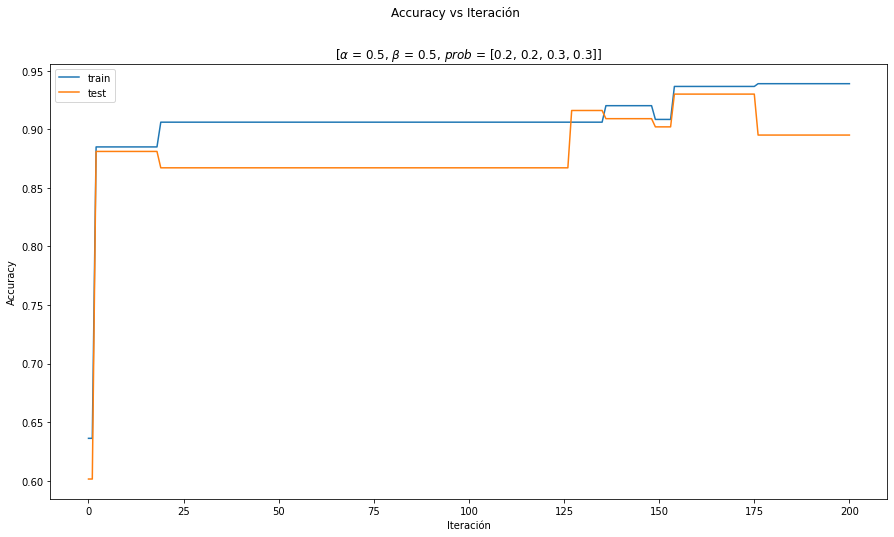

In [329]:
plot_accuracy(bayesian_tree , X_train, y_train, X_test, y_test)

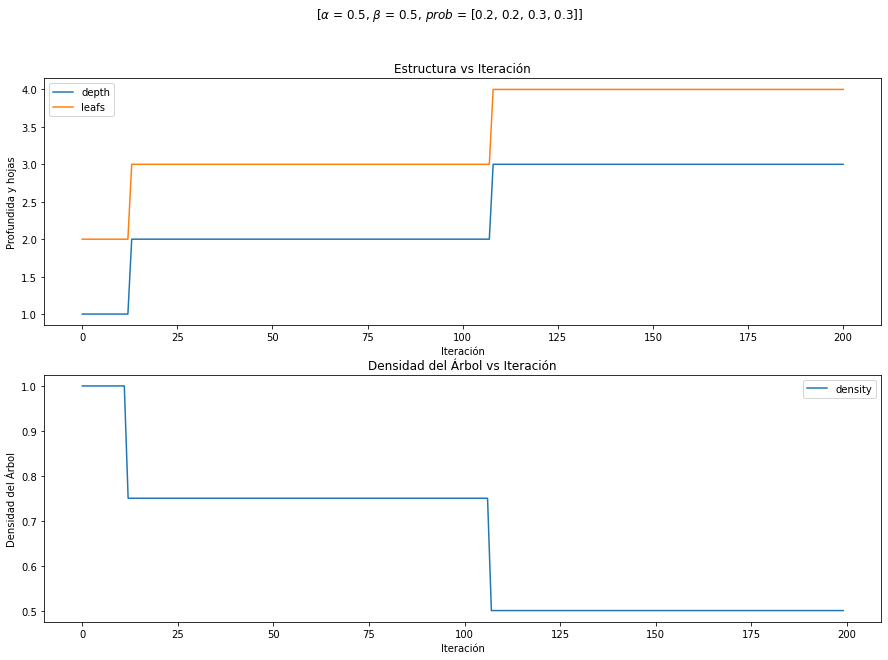

In [330]:
plot_info(bayesian_tree)

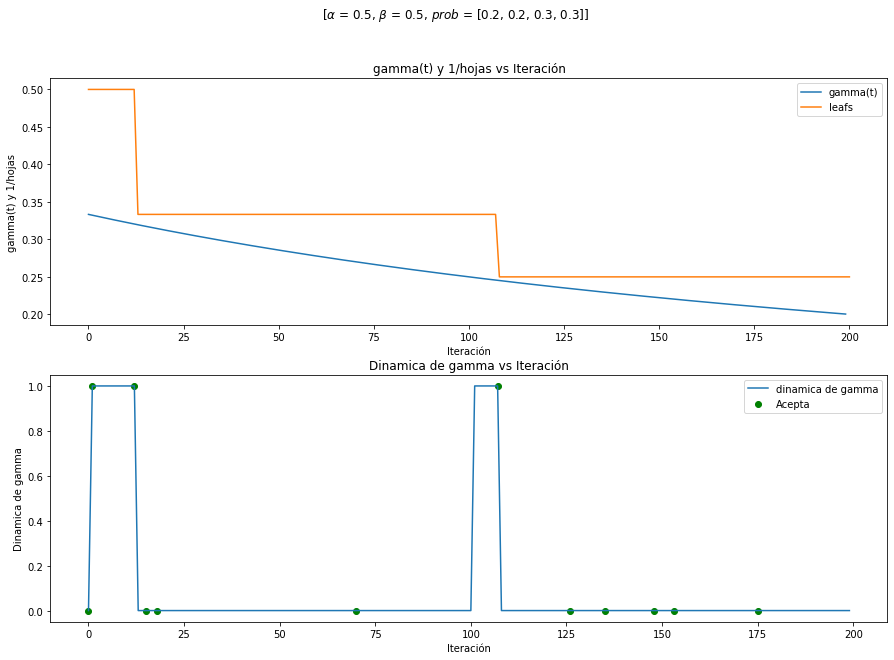

In [331]:
plot_inverse_leafs(bayesian_tree)

In [332]:
accuracy_test = bayesian_tree.path_acurracy(X_test,y_test)
idx_test_max = np.argmax(accuracy_test)
best_tree = bayesian_tree.path[idx_test_max]
best_tree.set_labels(feature_names,labels_names)
print(f"El mejor acurracy de testeo fue : {accuracy_test[idx_test_max]}")
# best_tree.save_img("Arboles5/1")

El mejor acurracy de testeo fue : 0.9300699300699301


In [333]:
print("Descisiones aceptadas: ")
print(np.array(bayesian_tree.choices)[bayesian_tree.chosen])

Descisiones aceptadas: 
['start' 'change' 'change' 'grow' 'change' 'change' 'change' 'grow'
 'change' 'change' 'change' 'change' 'change']


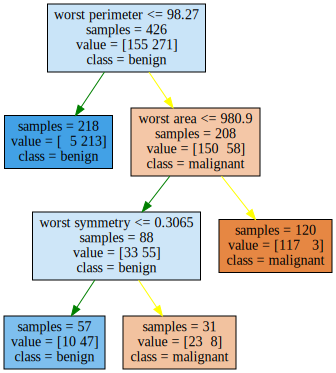

In [334]:
best_tree.graph_desiciontree()

In [335]:
# if not os.path.isdir("Change"):
#     os.mkdir("Change")
# for i,tree_chage in enumerate(bayesian_tree.tree_changes()):
#     tree_chage.save_img_hd(f"Change/{i}")

### Dataset de iris

In [342]:
iris = datasets.load_iris()
feature_names_iris = iris.feature_names
labels_names_iris = iris.target_names
X_iris = iris.data 
y_iris = iris.target
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, random_state= 42)

N_iris = 300
gamma_0_iris = cuadratic_gamma(N_iris)
gamma_1_iris = inverse_lineal(N_iris,5)

In [343]:
alpha, beta, prob = medium_search
bayesian_tree_iris = BC.BayesianDecisionTree(alpha = alpha, beta = beta, prob = prob, gamma_t=gamma_0_iris)
bayesian_tree_iris.fit(N_iris,X_iris_train,y_iris_train)

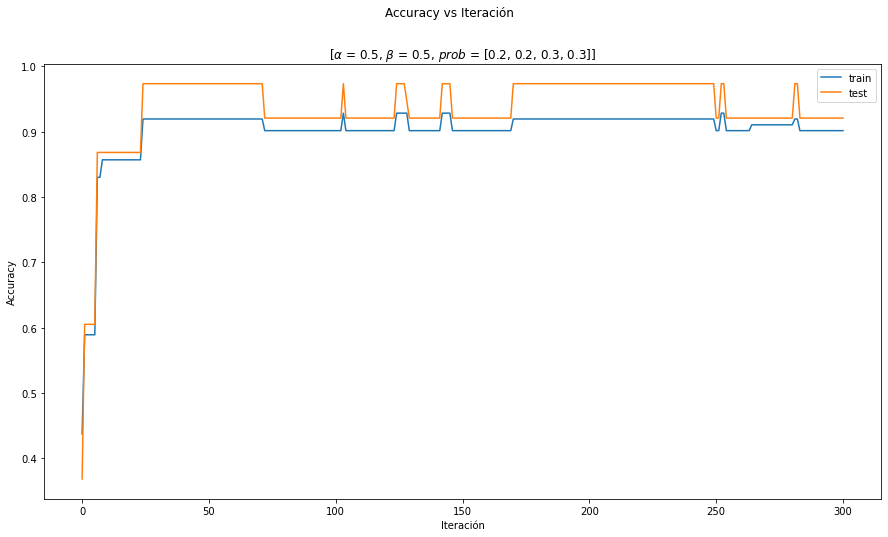

In [344]:
plot_accuracy(bayesian_tree_iris, X_iris_train, y_iris_train, X_iris_test, y_iris_test)

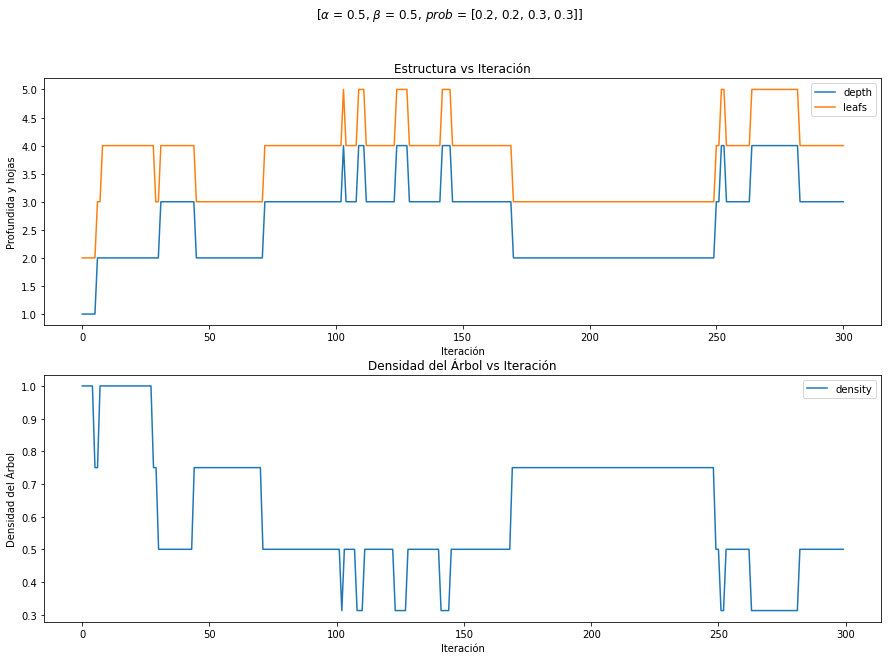

In [345]:
plot_info(bayesian_tree_iris)

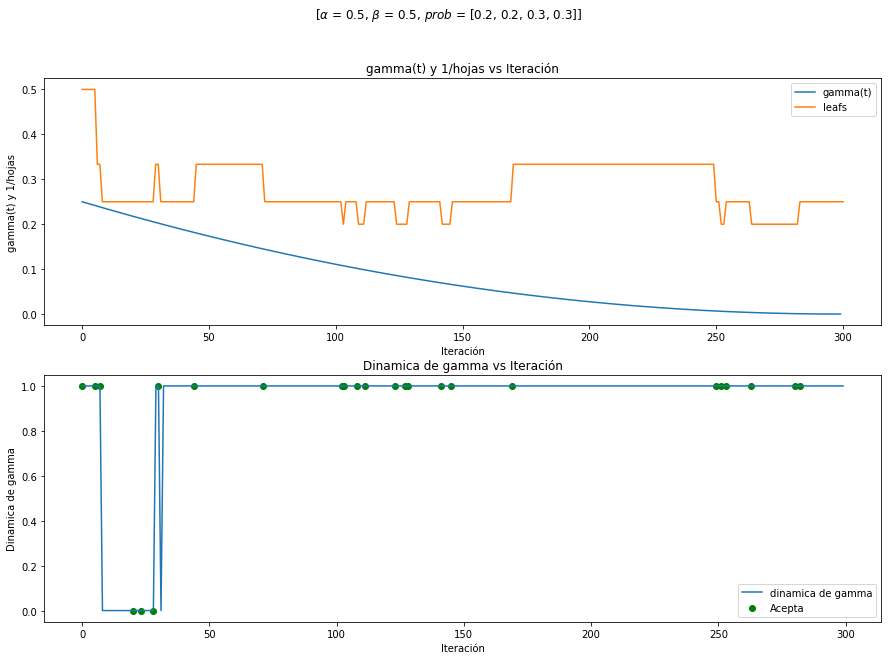

In [346]:
plot_inverse_leafs(bayesian_tree_iris)

In [347]:
path_iris = bayesian_tree_iris.path
accuracy_iris_test = bayesian_tree_iris.path_acurracy(X_iris_test, y_iris_test)
idx_test_max_iris = np.argmax(accuracy_iris_test)
best_tree_iris = path_iris[idx_test_max_iris]
best_tree_iris.set_labels(feature_names_iris,labels_names_iris)
print(f"El mejor acurracy de testeo fue : {accuracy_iris_test[idx_test_max_iris]}")


El mejor acurracy de testeo fue : 0.9736842105263158


In [348]:
print("Descisiones aceptadas: ")
print(np.array(bayesian_tree_iris.choices)[bayesian_tree_iris.chosen])

Descisiones aceptadas: 
['start' 'change' 'grow' 'grow' 'change' 'swap' 'prune' 'grow' 'prune'
 'grow' 'grow' 'prune' 'grow' 'prune' 'grow' 'change' 'prune' 'grow'
 'prune' 'prune' 'grow' 'grow' 'prune' 'grow' 'change' 'prune']


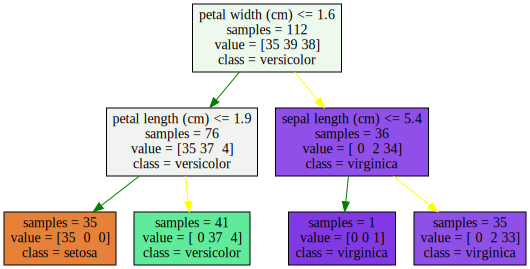

In [349]:
best_tree_iris.graph_desiciontree()

### Dataset de Digits

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


<Figure size 432x288 with 0 Axes>

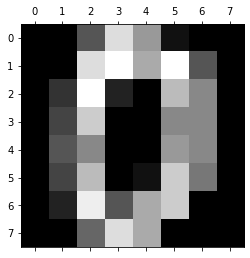

In [350]:
from sklearn.datasets import load_digits
digits=load_digits()
plt.gray() 
plt.matshow(digits.images[0]) 
print(digits.images[0])
plt.show() 

In [297]:
n_samples = len(digits.images)
data_digit = digits.images.reshape((n_samples, -1))
digits_target = digits.target
# digits_target0 =  digits_target[digits_target==0]
# digits_target1 =  digits_target[digits_target==1]
# digits_target2 =  digits_target[digits_target==2]
# digits_target2 =  digits_target[digits_target==3]

# data_digit0 =  data_digit[digits_target==0]
# data_digit1 =  data_digit[digits_target==1]
# data_digit2 =  data_digit[digits_target==2]

# data_digit = np.concatenate((data_digit0,data_digit1,data_digit2))
# digits_target = np.concatenate((digits_target0,digits_target1,digits_target2))

X_train_digit, X_test_digit, y_train_digit, y_test_digit = train_test_split(
    data_digit, digits_target, test_size=0.5, shuffle=True , random_state=22)

In [298]:
feature_names_digit = digits.feature_names
labels_names_digit = digits.target_names

 ####  $\alpha=0.5, \beta= 0.5,prob = [0.25,0.25,0.25,0.25]$

In [352]:
N_digits = 2000
gamma_0_digits = sqrt_gamma(N_digits)
gamma_1_digits = inverse_lineal(N_digits,30)

In [353]:
bayesian_tree_digit = BC.BayesianDecisionTree(alpha=0.5, beta= 0.5,prob = [0.25,0.25,0.25,0.25], gamma_t=gamma_1_digits)
bayesian_tree_digit.fit(N_digits,X_train_digit ,y_train_digit)

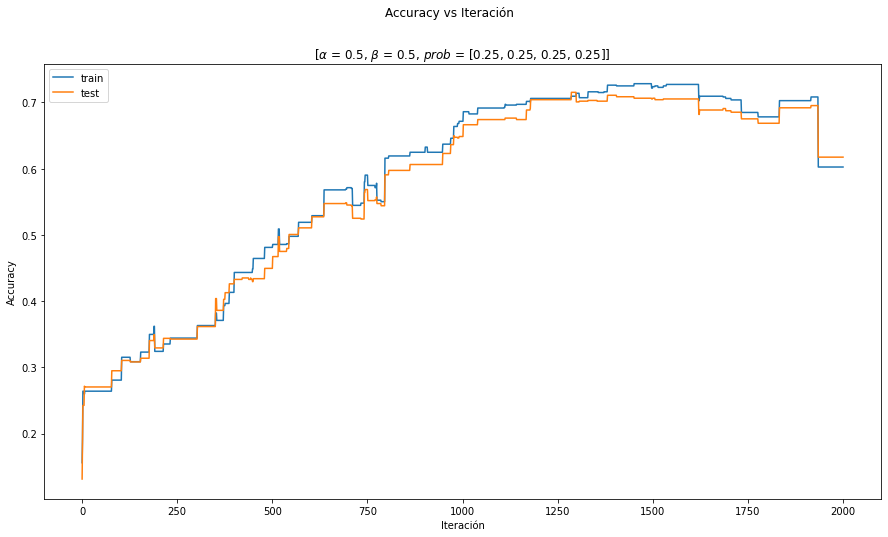

In [354]:
plot_accuracy(bayesian_tree_digit, X_train_digit, y_train_digit, X_test_digit, y_test_digit)

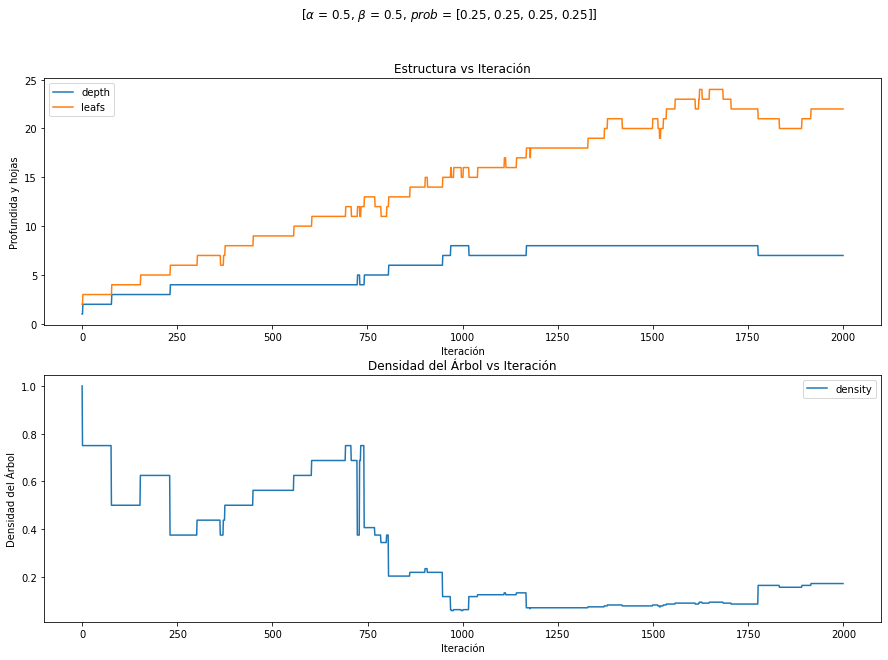

In [355]:
plot_info(bayesian_tree_digit)

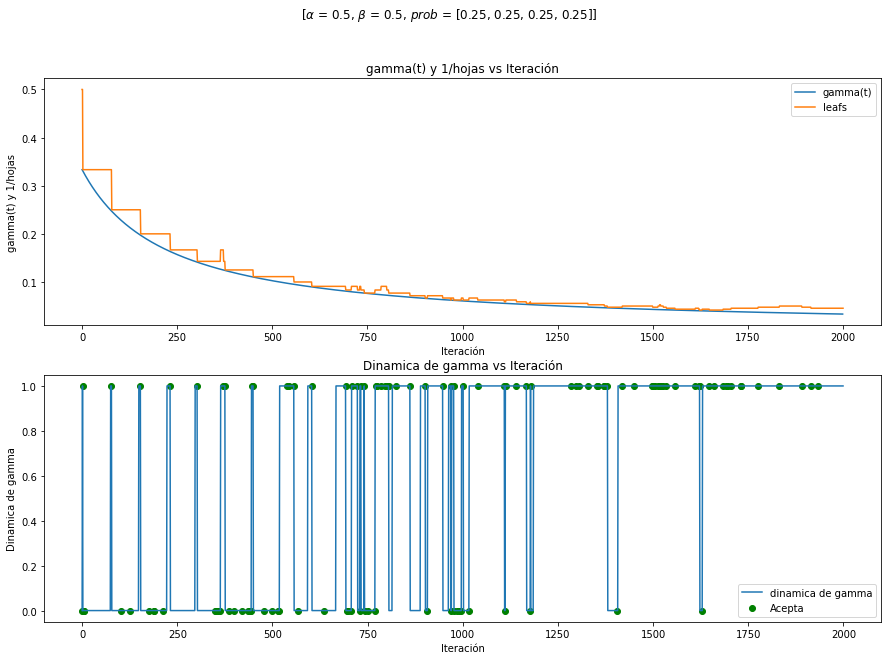

In [356]:
plot_inverse_leafs(bayesian_tree_digit)

In [357]:
path_digit = bayesian_tree_digit.path
accuracy_digit_test = bayesian_tree_digit.path_acurracy(X_test_digit, y_test_digit)
idx_test_max_digit = np.argmax(accuracy_digit_test)
best_tree_digit = path_digit[idx_test_max_digit]
best_tree_digit.set_labels(feature_names_digit,labels_names_digit)
print(f"El mejor acurracy de testeo fue : {accuracy_digit_test[idx_test_max_digit]}")


El mejor acurracy de testeo fue : 0.7152391546162402


In [358]:
print("Descisiones aceptadas: ")
print(np.array(bayesian_tree_digit.choices)[bayesian_tree_digit.chosen])

Descisiones aceptadas: 
['start' 'change' 'grow' 'change' 'swap' 'grow' 'change' 'change' 'grow'
 'change' 'change' 'change' 'change' 'grow' 'grow' 'change' 'change'
 'change' 'prune' 'grow' 'grow' 'change' 'swap' 'swap' 'swap' 'swap'
 'swap' 'change' 'grow' 'change' 'change' 'change' 'change' 'change'
 'change' 'grow' 'change' 'grow' 'change' 'grow' 'change' 'swap' 'prune'
 'change' 'grow' 'prune' 'grow' 'grow' 'change' 'change' 'prune' 'swap'
 'swap' 'prune' 'change' 'grow' 'grow' 'change' 'grow' 'grow' 'prune'
 'grow' 'grow' 'prune' 'grow' 'swap' 'swap' 'change' 'prune' 'grow'
 'prune' 'grow' 'grow' 'change' 'prune' 'grow' 'grow' 'prune' 'grow'
 'change' 'change' 'change' 'grow' 'change' 'swap' 'swap' 'grow' 'grow'
 'swap' 'prune' 'change' 'change' 'grow' 'change' 'prune' 'prune' 'grow'
 'grow' 'grow' 'grow' 'prune' 'grow' 'grow' 'prune' 'grow' 'swap' 'prune'
 'change' 'swap' 'prune' 'swap' 'swap' 'prune' 'prune' 'grow' 'grow'
 'change']


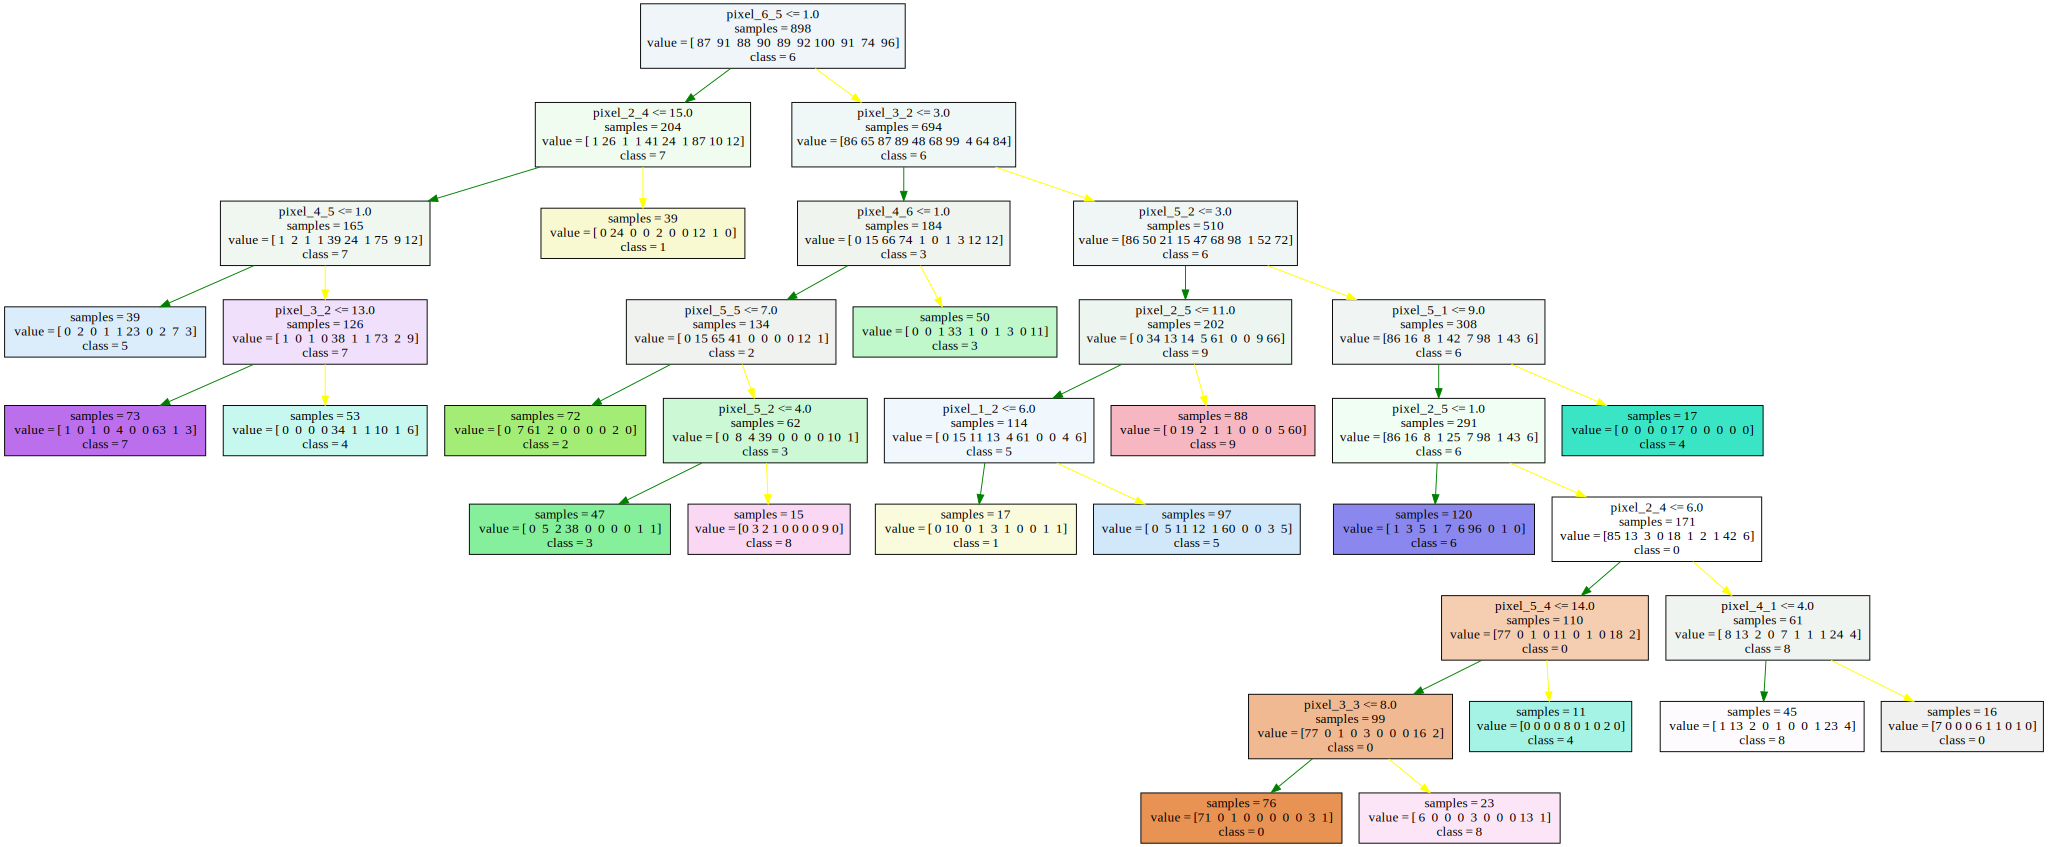

In [359]:
best_tree_digit.graph_desiciontree()

In [160]:
# best_tree_digit.save_img_hd("Digits/best")

              precision    recall  f1-score   support

           0       0.86      0.91      0.88        91
           1       0.50      0.32      0.39        91
           2       0.79      0.69      0.73        89
           3       0.77      0.72      0.74        93
           4       0.83      0.73      0.77        92
           5       0.55      0.81      0.66        90
           6       0.77      0.96      0.86        81
           7       0.93      0.75      0.83        88
           8       0.63      0.63      0.63       100
           9       0.59      0.67      0.63        84

    accuracy                           0.72       899
   macro avg       0.72      0.72      0.71       899
weighted avg       0.72      0.72      0.71       899

[[83  0  0  0  2  0  1  0  5  0]
 [ 5 29  5  2  0 16  2  0  9 23]
 [ 0  0 61  7  0 10  1  0  9  1]
 [ 1  0  4 67  0 11  2  2  2  4]
 [ 5 10  0  0 67  4  5  1  0  0]
 [ 1  1  0  0  2 73 11  0  1  1]
 [ 1  0  0  1  0  0 78  0  1  0]
 [ 0 13  0

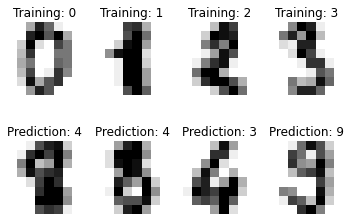

In [360]:
y_pred_digit = best_tree_digit.predict(X_test_digit)

_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

    images_and_predictions = list(zip(digits.images[n_samples // 2:], y_pred_digit))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print((metrics.classification_report(y_test_digit, y_pred_digit)))
print((metrics.confusion_matrix(y_test_digit, y_pred_digit)))

### Probamos distintos parametros

 ####  $\alpha=0.85, \beta= 0.5,prob = [0.25,0.25,0.25,0.25]$

In [361]:
N_digits2 = 2000
gamma_0_digits2 = even_gamma(N_digits2)
gamma_1_digits2 = inverse_lineal(N_digits2,30)

In [362]:
bayesian_tree_digit2 = BC.BayesianDecisionTree(alpha=0.85, beta= 0.5,prob = [0.25,0.25,0.25,0.25], gamma_t=gamma_0_digits2)
bayesian_tree_digit2.fit(N_digits2,X_train_digit ,y_train_digit)

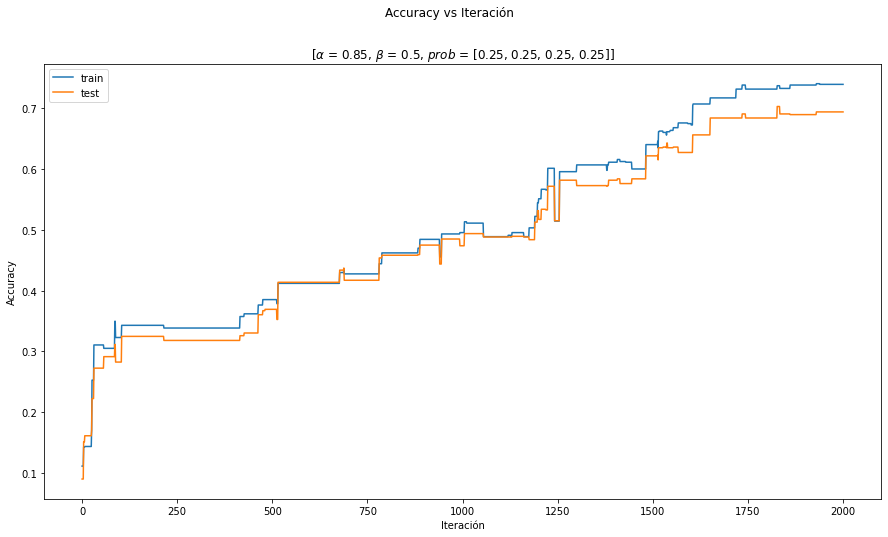

In [363]:
plot_accuracy(bayesian_tree_digit2, X_train_digit, y_train_digit, X_test_digit, y_test_digit)

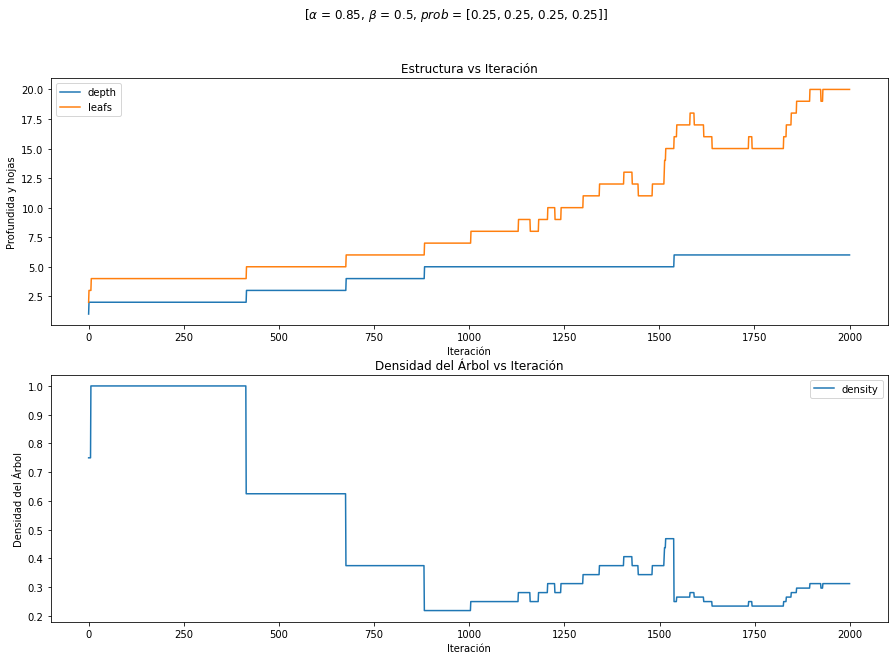

In [364]:
plot_info(bayesian_tree_digit2)

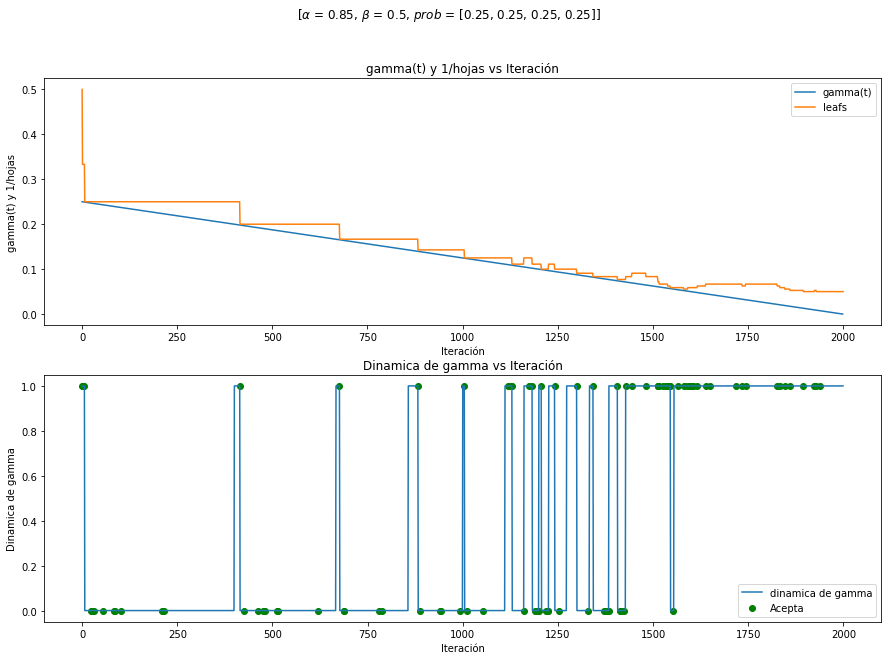

In [365]:
plot_inverse_leafs(bayesian_tree_digit2)

In [366]:
path_digit2 = bayesian_tree_digit2.path
accuracy_digit_test2 = bayesian_tree_digit2.path_acurracy(X_test_digit, y_test_digit)
idx_test_max_digit2 = np.argmax(accuracy_digit_test2)
best_tree_digit2 = path_digit2[idx_test_max_digit2]
best_tree_digit2.set_labels(feature_names_digit,labels_names_digit)
print(f"El mejor acurracy de testeo fue : {accuracy_digit_test2[idx_test_max_digit2]}")

El mejor acurracy de testeo fue : 0.7030033370411568


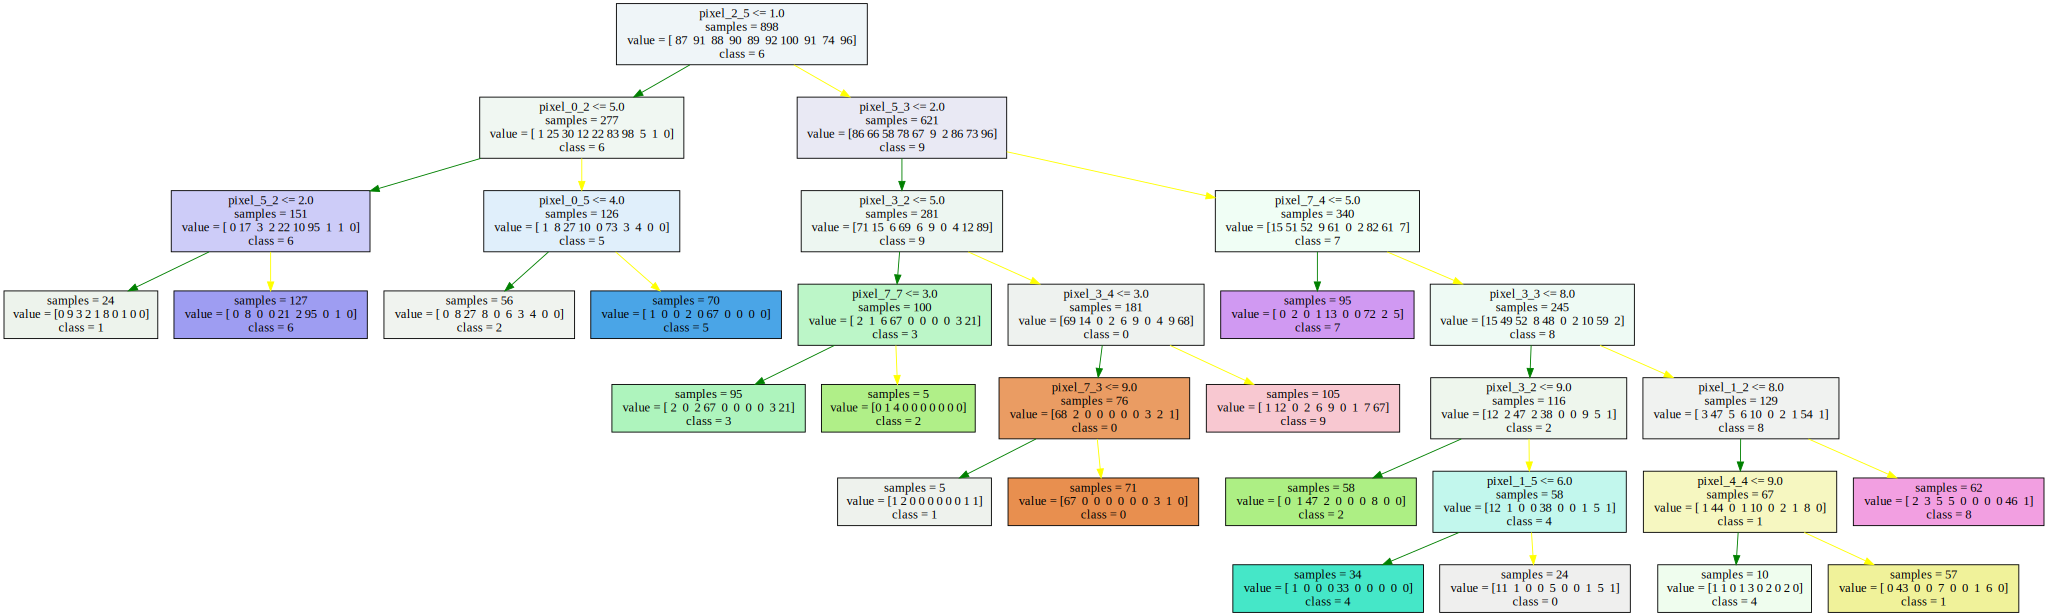

In [367]:
best_tree_digit2.graph_desiciontree()

              precision    recall  f1-score   support

           0       0.81      0.86      0.83        91
           1       0.55      0.48      0.51        91
           2       0.63      0.78      0.70        89
           3       0.75      0.74      0.75        93
           4       0.75      0.43      0.55        92
           5       0.99      0.74      0.85        90
           6       0.68      0.90      0.77        81
           7       0.77      0.73      0.75        88
           8       0.61      0.68      0.64       100
           9       0.61      0.71      0.66        84

    accuracy                           0.70       899
   macro avg       0.72      0.71      0.70       899
weighted avg       0.72      0.70      0.70       899

[[78  0  1  2  6  0  1  0  2  1]
 [ 0 44 13  2  3  1  5  2 10 11]
 [ 2  1 69  0  1  0  0  2 14  0]
 [ 1  1  6 69  0  0  1  1  9  5]
 [ 5 16  0  0 40  0 20  7  1  3]
 [ 0  4  1  0  0 67  7  2  0  9]
 [ 1  0  6  0  1  0 73  0  0  0]
 [ 2  4 11

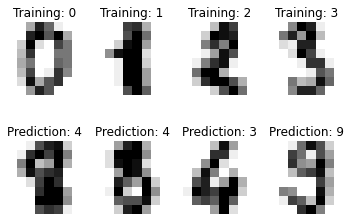

In [368]:
y_pred_digit2 = best_tree_digit2.predict(X_test_digit)

_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

    images_and_predictions = list(zip(digits.images[n_samples // 2:], y_pred_digit))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print((metrics.classification_report(y_test_digit, y_pred_digit2)))
print((metrics.confusion_matrix(y_test_digit, y_pred_digit2)))

 ####  $\alpha=0.5, \beta= 0.5,prob = [0.1,0.1,0.4,0.4]$

In [378]:
N_digits3 = 2000
gamma_0_digits3 = even_gamma(N_digits3)
gamma_1_digits3 = inverse_lineal(N_digits3, 30)


In [379]:
bayesian_tree_digit3 = BC.BayesianDecisionTree(alpha=0.01, beta= 0.5,prob = [0.1,0.1,0.4,0.4], gamma_t=gamma_1_digits3)
bayesian_tree_digit3.fit(N_digits3,X_train_digit ,y_train_digit)

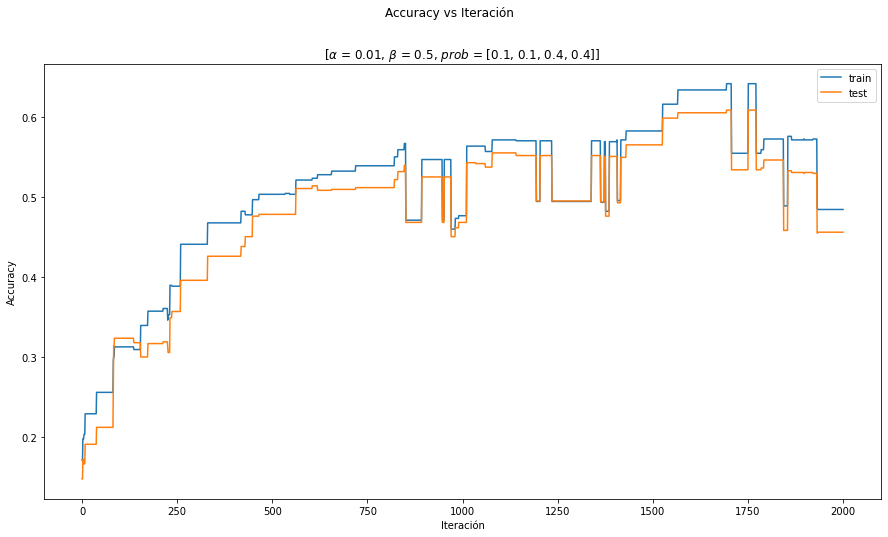

In [380]:
plot_accuracy(bayesian_tree_digit3, X_train_digit, y_train_digit, X_test_digit, y_test_digit)

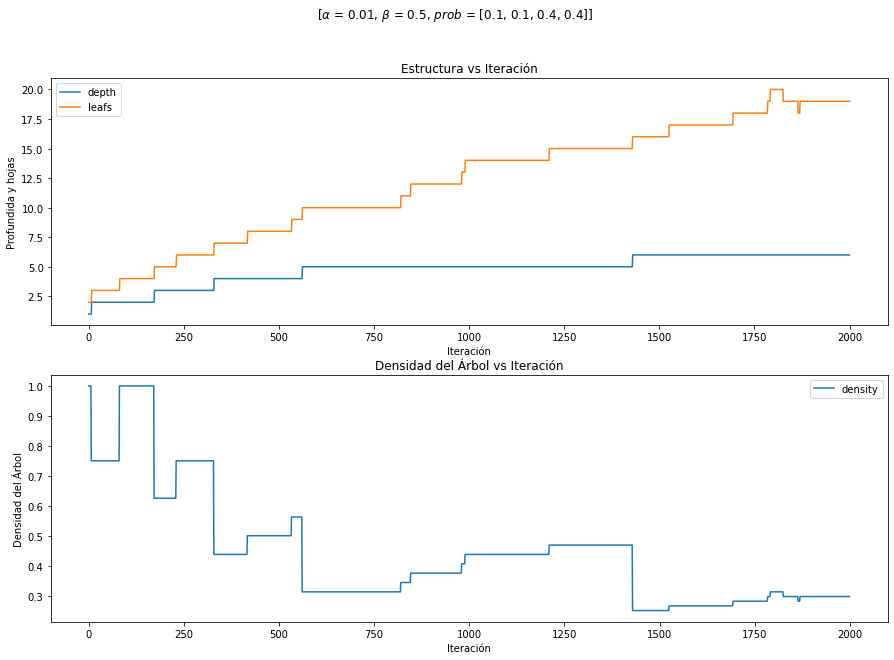

In [381]:
plot_info(bayesian_tree_digit3)

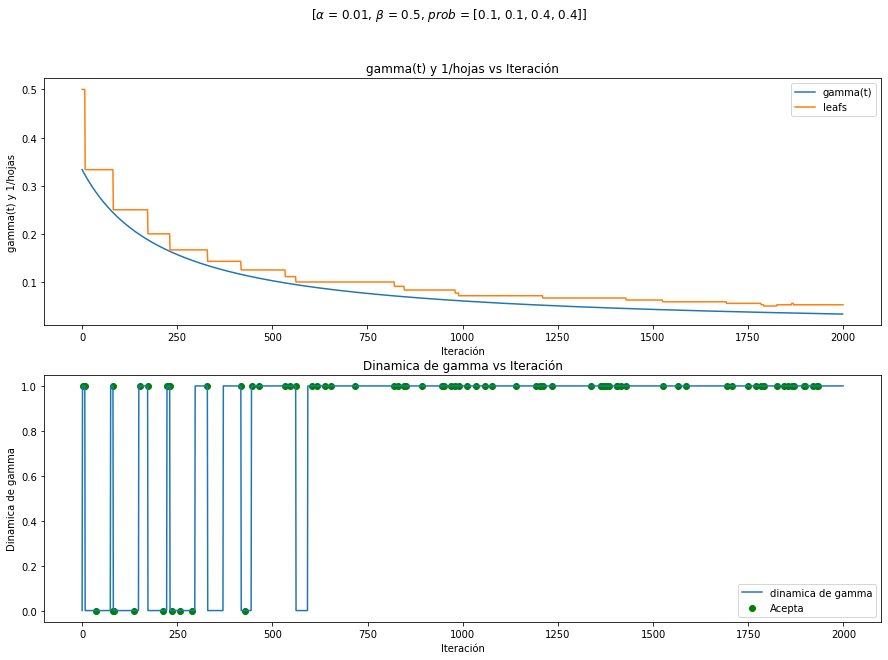

In [382]:
plot_inverse_leafs(bayesian_tree_digit3)

In [383]:
path_digit3 = bayesian_tree_digit3.path
accuracy_digit_test3 = bayesian_tree_digit3.path_acurracy(X_test_digit, y_test_digit)
idx_test_max_digit3 = np.argmax(accuracy_digit_test3)
best_tree_digit3 = path_digit3[idx_test_max_digit3]
best_tree_digit3.set_labels(feature_names_digit,labels_names_digit)
print(accuracy_digit_test3[idx_test_max_digit3])

0.6084538375973304


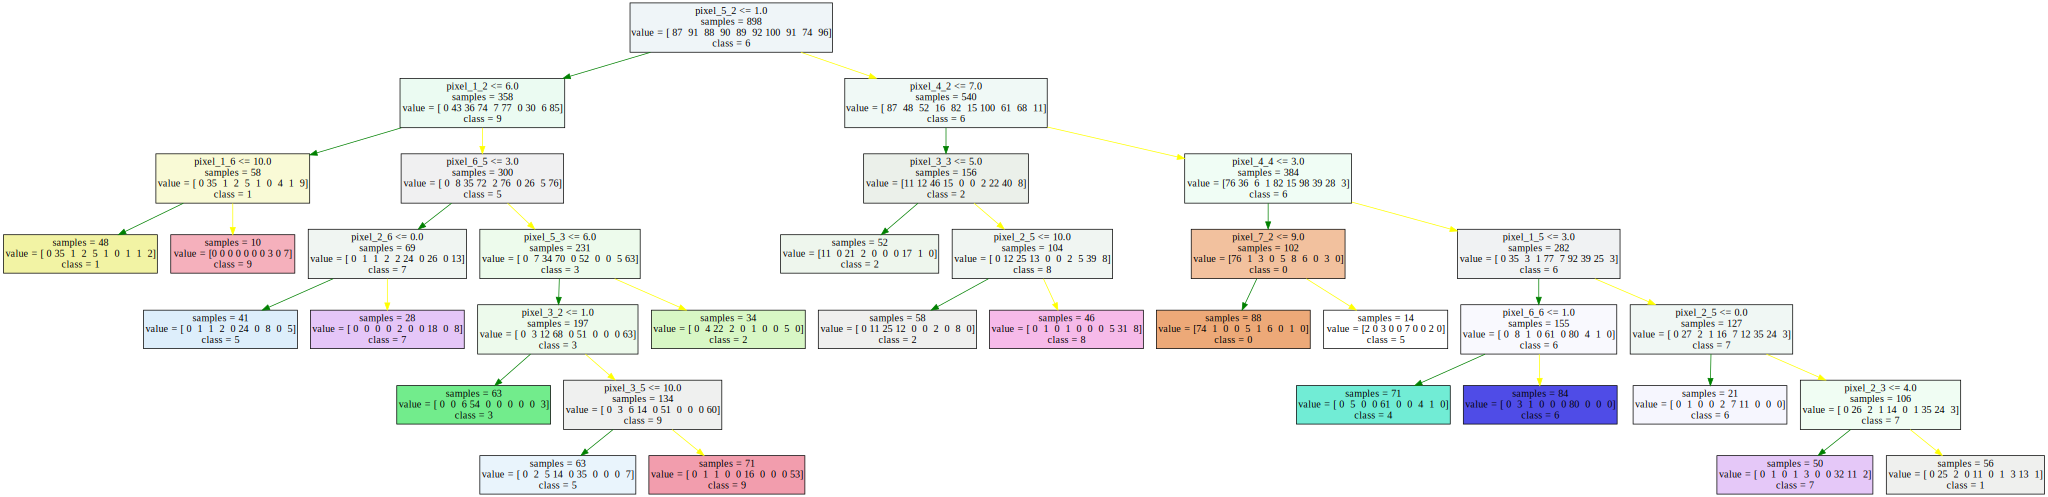

In [384]:
best_tree_digit3.graph_desiciontree()

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        91
           1       0.39      0.63      0.48        91
           2       0.48      0.83      0.61        89
           3       0.91      0.42      0.57        93
           4       0.79      0.60      0.68        92
           5       0.50      0.41      0.45        90
           6       0.86      0.85      0.86        81
           7       0.50      0.66      0.57        88
           8       0.53      0.28      0.37       100
           9       0.72      0.60      0.65        84

    accuracy                           0.61       899
   macro avg       0.65      0.62      0.61       899
weighted avg       0.65      0.61      0.61       899

[[80  2  3  0  0  6  0  0  0  0]
 [ 1 57 16  1  5  4  1  1  4  1]
 [ 0  1 74  2  0  5  0  0  3  4]
 [ 0  6 14 39  0 17  1 11  4  1]
 [ 6 23  1  0 55  0  2  3  1  1]
 [ 1  4 10  0  2 37  3 25  0  8]
 [ 2  7  1  0  2  0 69  0  0  0]
 [ 0  8 14

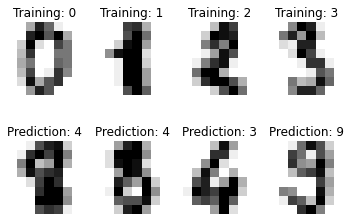

In [385]:
y_pred_digit3 = best_tree_digit3.predict(X_test_digit)

_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

    images_and_predictions = list(zip(digits.images[n_samples // 2:], y_pred_digit))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print((metrics.classification_report(y_test_digit, y_pred_digit3)))
print((metrics.confusion_matrix(y_test_digit, y_pred_digit3)))